# EMNIST DataSet Project

**Mohammad Mazrouei** \
**4003613056** 

# Imports

In [70]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# Data Preparation 

**Transformations**  
Compose is used to combine multiple transformations into one.  
ToTensor() converts a PIL image or NumPy ndarray to a tensor.  
lambda reshapes the tensor into a 1D tensor with 784 elements (28x28 = 784), which is the flattened version of the MNIST images.  

**Load Dataset**  
The MNIST class is used to download and load the MNIST dataset, applying the transformations to each image in the dataset.  

**Show Data**  
show_image(tensor) function reshapes the flattened tensor back to 28x28 and displays it using plt.imshow.  

In [71]:
transform = Compose([
    ToTensor(),
    Lambda(lambda image: image.view(784))
])

data_train = MNIST(root="./", download=True, train=True, transform=transform)
data_test = MNIST(root="./", download=True, train=False, transform=transform)

In [72]:
print(f'#NO train data: {len(data_train)}')
print(f'#NO test data:  {len(data_test)}')

#NO train data: 60000
#NO test data:  10000


In [73]:
data_train[0][0].shape

torch.Size([784])

/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecation

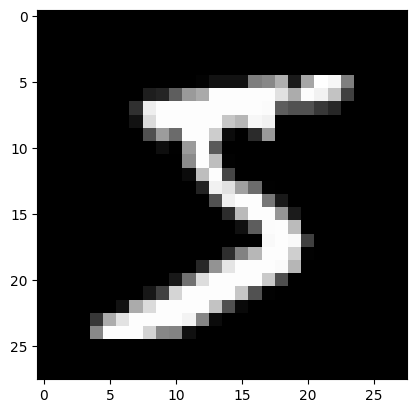

5


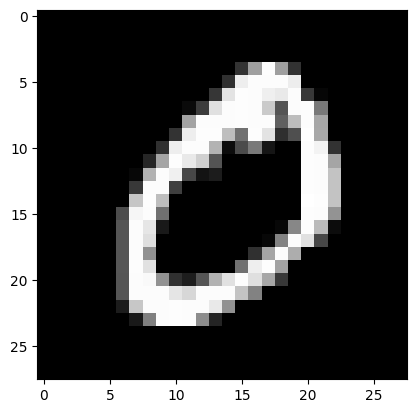

0


In [74]:
def show_image(tensor):
    # Reshape the tensor back to 28x28
    image = tensor.view(28, 28)
    plt.imshow(image, cmap='gray')
    plt.show()

sample_image, label = data_train[0]
show_image(sample_image)
print(label)

sample_image, label = data_train[1]
show_image(sample_image)
print(label)

# Model Architecture  

**get_default_device**, This function checks if a GPU (CUDA) is available and returns the corresponding device.  
**to_t**, This function transfers a given tensor to the specified device.  

In [75]:
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_t(tensor, device=get_default_device()):
    return tensor.to(device)

**Explain Model**  

**init Method**  
*Parameters:*  
input_size=784: Number of input features (default is 784 for flattened 28x28 MNIST images).  
hidden_layers=[512]: List specifying the number of neurons in each hidden layer.  
output_size=10: Number of output features (default is 10 for the MNIST classification task).  

*Sequential Layers:*  
self.layers = nn.Sequential(*layers): Combines all the layers into a sequential container.  

*Loss Function:*  
self.loss = nn.CrossEntropyLoss(): Defines the cross-entropy loss function, suitable for classification.  

*Optimizer:*  
self.optimizer = optim.Adam(self.parameters()): Defines the Adam optimizer to update model parameters during training.  

*Device Transfer:*  
self.to(get_default_device()): Moves the model to the appropriate device (CPU or GPU).  

**forward Method**  
Takes input X and passes it through the defined layers.  
Returns the output of the final layer.  

**predict Method**  
Disables gradient calculation using torch.no_grad() for prediction to save memory and computation.  
Passes the input X through the model to get the output logits.  
Uses torch.argmax to get the index of the highest logit, which corresponds to the predicted class.  

**fit Method**  
*Zero Gradients:*  
self.optimizer.zero_grad(): Clears the gradients of all optimized tensors.  
*Forward Pass:*  
y_pred = self.forward(X): Computes the forward pass to get the predicted output.  
*Compute Loss:*  
loss = self.loss(y_pred, Y): Calculates the loss between the predicted output y_pred and the true labels Y.  
*Backward Pass:*  
loss.backward(): Backpropagates the error to compute gradients.  
*Optimizer Step:*  
self.optimizer.step(): Updates the model parameters based on the gradients.  
*Return Loss:*  
return loss.item(): Returns the scalar value of the loss for monitoring training progress.  

In [76]:
class Model(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[512], output_size=10):
        super().__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.Sequential(*layers)
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

**BATCH_SIZE:** The number of samples processed before the model is updated.  
**EPOCHS:** The number of complete passes through the training dataset.  
**dataloader_train:** Loads the training dataset in batches of size BATCH_SIZE and shuffles the data.  
**dataloader_test:** Loads the test dataset in batches of size BATCH_SIZE and shuffles the data.  

In [77]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

**train_the_model:** Returns the list of average losses for all epochs.  

In [78]:
def train_the_model(mnist_model):
    tot_loss = []
    for i in range(EPOCHS):
        total_loss = 0
        for r_xs, r_ys in dataloader_train:
            xs, ys = to_t(r_xs), to_t(r_ys)
            total_loss += mnist_model.fit(xs, ys)
        total_loss /= len(dataloader_train)
        tot_loss.append(total_loss)
        print(f"EPOCH {i + 1}: {total_loss:.4f}")
    return tot_loss

In [79]:
def plot_loss_curve(loss, label):
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

**How to adjust the number of layers and the number of neurons in each layer?**  
To calculate the best value for the number of layers and neurons inside each layer,  
we first consider the rest of the parameters constant and run the model for different values.  

**Effect of Number of Layers and Neurons**  
*Underfitting:*  
Model1 and Model2: These models underfit due to insufficient neurons. They are too simple to capture the complexities of the data.  
Indicators: High loss values and slow improvement across epochs.  

*Balanced Fit:*  
Model3 and Model4: These models balance capacity and performance well. They have enough neurons to learn the data without being too complex.  
Indicators: Rapid decrease in loss values and lower final loss.  

*Overfitting:*  
Model5, Model6, Model7, Model8: These models do not show clear signs of overfitting within 5 epochs, but their increased complexity suggests a higher risk if trained longer.  
Indicators: Very low loss values, potentially marginal improvement over simpler models, increased computational cost.  

**Best Model**  
Model4 (hidden_layers = [512]) the best model considering the following factors:  
Performance: It achieves low loss values early in training, comparable to larger models.  
Simplicity: It maintains simplicity with a single hidden layer, reducing the risk of overfitting and computational cost.  

EPOCH 1: 1.4501
EPOCH 2: 1.1244
EPOCH 3: 1.0722
EPOCH 4: 1.0486
EPOCH 5: 1.0330


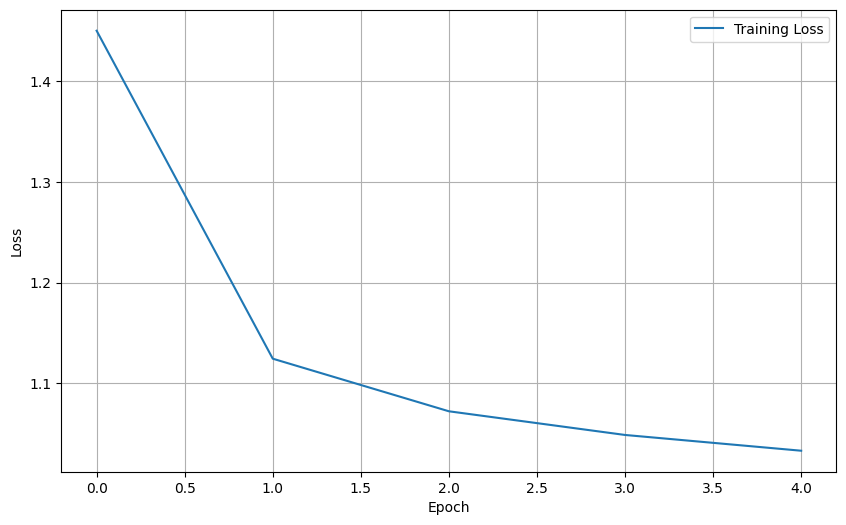

In [80]:
model1 = Model(hidden_layers = [2])
training_loss_model1 = train_the_model(model1)
plot_loss_curve(loss=training_loss_model1, label='Training Loss')

EPOCH 1: 0.4949
EPOCH 2: 0.3189
EPOCH 3: 0.2983
EPOCH 4: 0.2857
EPOCH 5: 0.2781


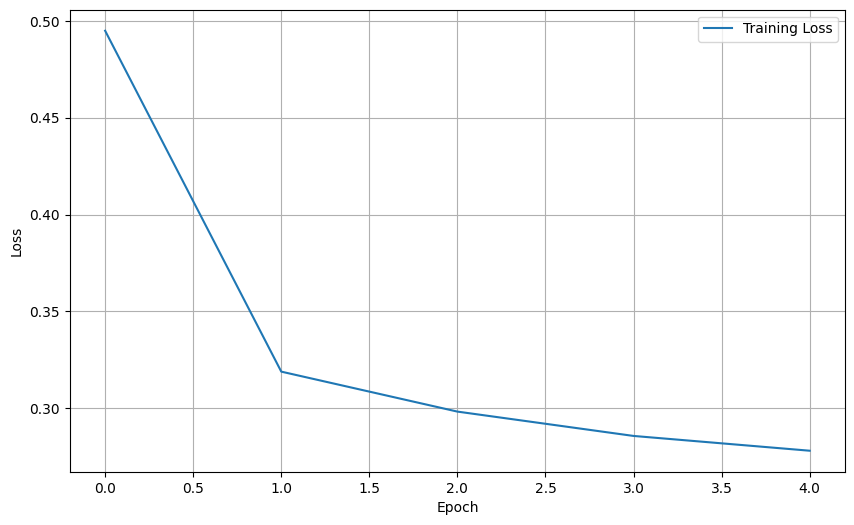

In [81]:
model2 = Model(hidden_layers = [8])
training_loss_model2 = train_the_model(model2)
plot_loss_curve(loss=training_loss_model2, label='Training Loss')

EPOCH 1: 0.2257
EPOCH 2: 0.0929
EPOCH 3: 0.0615
EPOCH 4: 0.0451
EPOCH 5: 0.0336


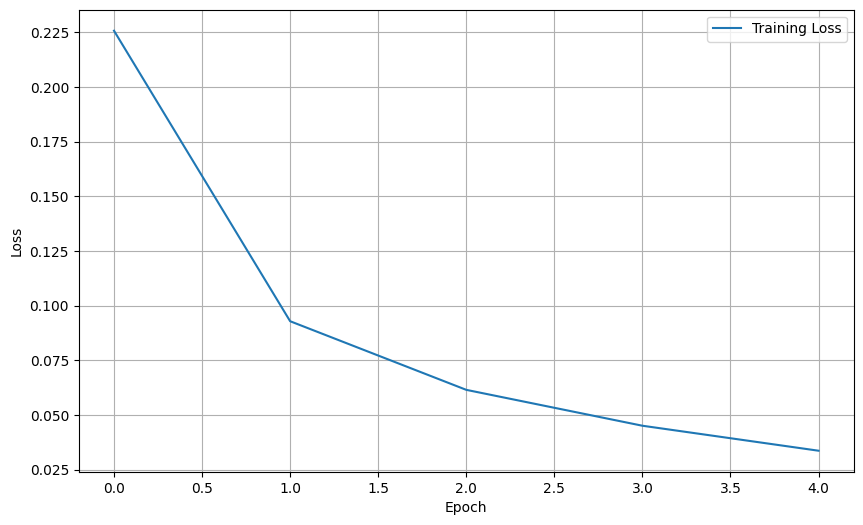

In [82]:
model3 = Model(hidden_layers = [256])
training_loss_model3 = train_the_model(model3)
plot_loss_curve(loss=training_loss_model3, label='Training Loss')

EPOCH 1: 0.1981
EPOCH 2: 0.0809
EPOCH 3: 0.0547
EPOCH 4: 0.0380
EPOCH 5: 0.0298


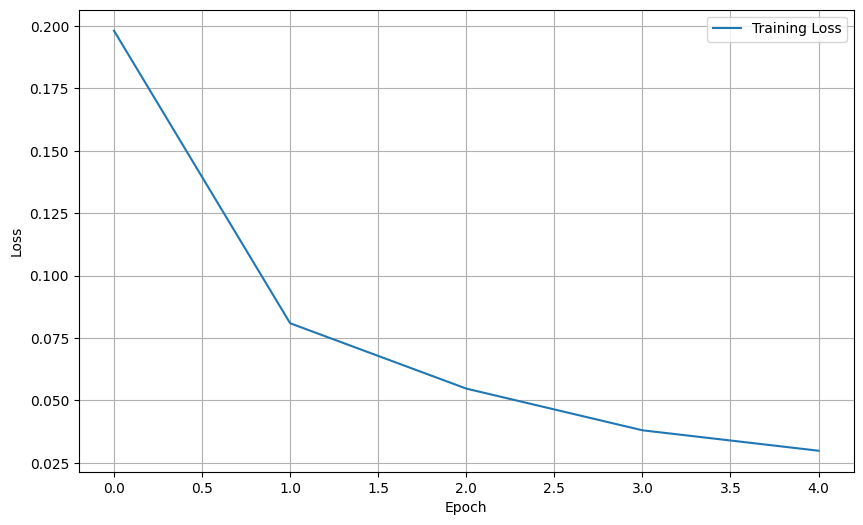

In [83]:
model4 = Model(hidden_layers = [512])
training_loss_model4 = train_the_model(model4)
plot_loss_curve(loss=training_loss_model4, label='Training Loss')

EPOCH 1: 0.1833
EPOCH 2: 0.0750
EPOCH 3: 0.0513
EPOCH 4: 0.0375
EPOCH 5: 0.0300


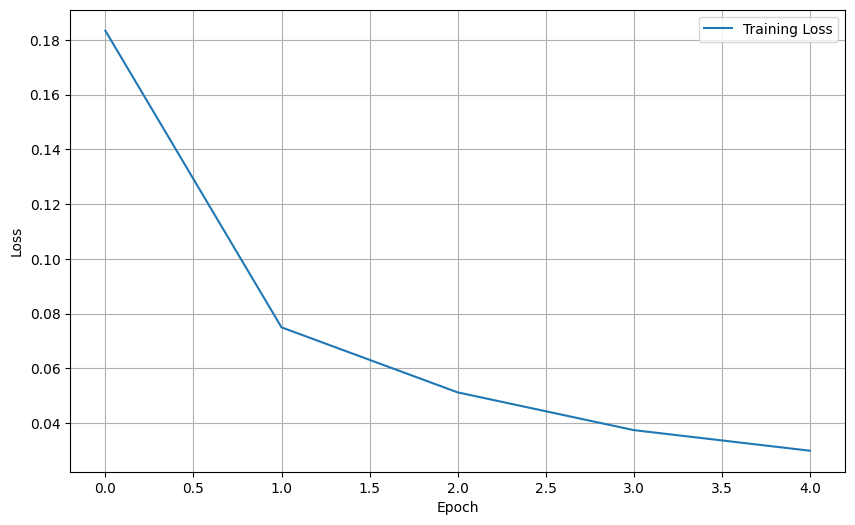

In [84]:
model5 = Model(hidden_layers = [1024])
training_loss_model5 = train_the_model(model5)
plot_loss_curve(loss=training_loss_model5, label='Training Loss')

EPOCH 1: 0.1954
EPOCH 2: 0.0882
EPOCH 3: 0.0622
EPOCH 4: 0.0503
EPOCH 5: 0.0408


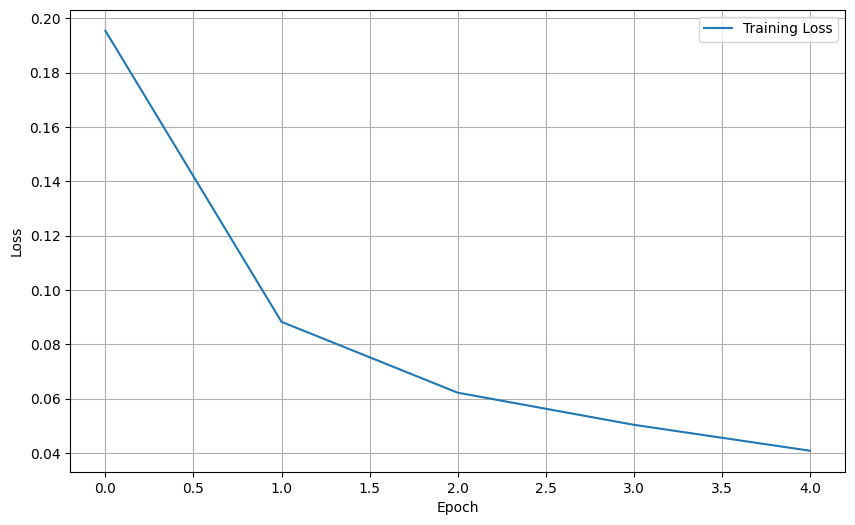

In [85]:
model6 = Model(hidden_layers = [512, 512])
training_loss_model6 = train_the_model(model6)
plot_loss_curve(loss=training_loss_model6, label='Training Loss')

EPOCH 1: 0.2172
EPOCH 2: 0.1042
EPOCH 3: 0.0736
EPOCH 4: 0.0579
EPOCH 5: 0.0487


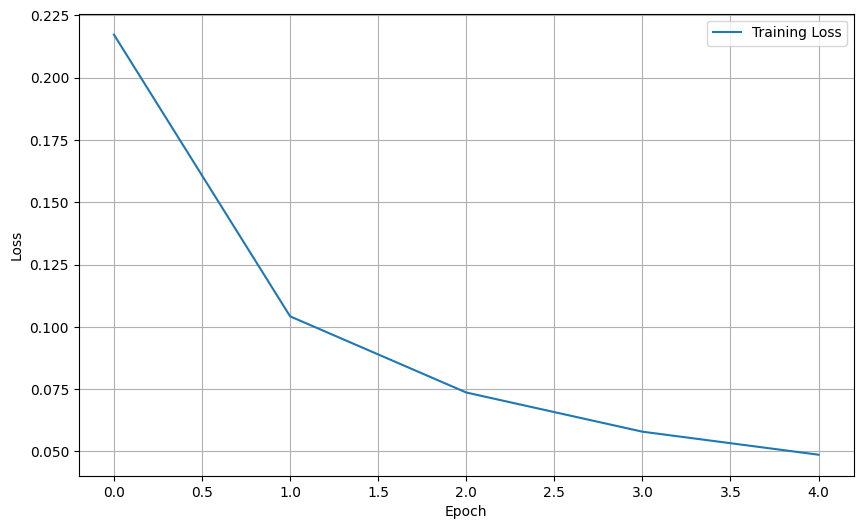

In [86]:
model7 = Model(hidden_layers = [512, 256, 512])
training_loss_model7 = train_the_model(model7)
plot_loss_curve(loss=training_loss_model7, label='Training Loss')

EPOCH 1: 0.2445
EPOCH 2: 0.1168
EPOCH 3: 0.0861
EPOCH 4: 0.0705
EPOCH 5: 0.0589


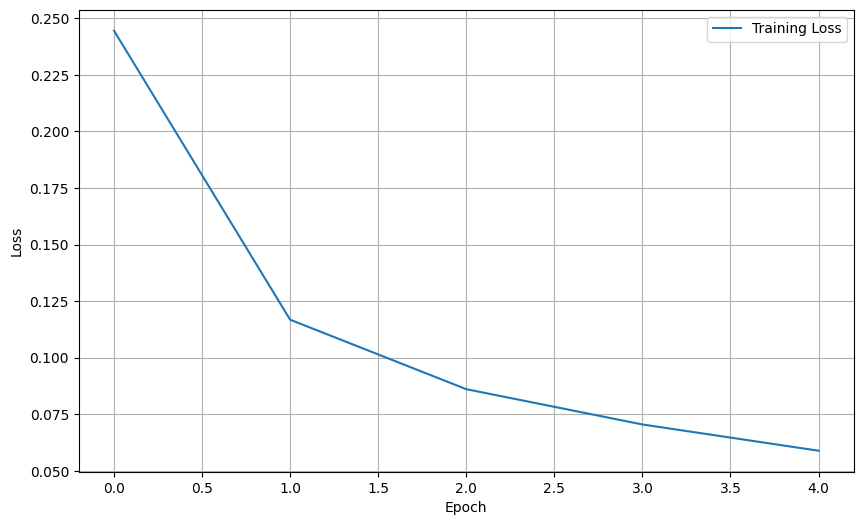

In [87]:
model8 = Model(hidden_layers = [512, 256, 256, 512])
training_loss_model8 = train_the_model(model8)
plot_loss_curve(loss=training_loss_model8, label='Training Loss')